<a href="https://colab.research.google.com/github/andojas/Deep-Markov-Model/blob/master/PROFASI_HB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://www.github.com/google/jax-md

     |████████████████████████████████| 245kB 5.2MB/s 


In [ ]:
!pip install --upgrade -q https://storage.googleapis.com/jax-releases/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-$(pip search jaxlib | grep -oP '[0-9\.]+' | head -n 1)-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax
!pip install -q git+https://www.github.com/google/jax-md

  ERROR: HTTP error 404 while getting https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.55-cp36-none-linux_x86_64.whl
  ERROR: Could not install requirement jaxlib==0.1.55 from https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.55-cp36-none-linux_x86_64.whl because of error 404 Client Error: Not Found for url: https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.55-cp36-none-linux_x86_64.whl
ERROR: Could not install requirement jaxlib==0.1.55 from https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.55-cp36-none-linux_x86_64.whl because of HTTP error 404 Client Error: Not Found for url: https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.55-cp36-none-linux_x86_64.whl for URL https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.55-cp36-none-linux_x86_64.whl
     |████████████████████████████████| 450kB 5.0MB/s 
     |████████████████████████████████| 245kB 4.8MB/s 


In [2]:
import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util

from functools import partial
import time

f32 = np.float32
f64 = np.float64

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
#import seaborn as sns 
#sns.set_style(style='white')

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def calculate_bond_data(displacement_or_metric, R, dr_cutoff, species=None):
  if( not(species is None)):
    assert(False)
    
  metric = space.map_product(space.canonicalize_displacement_or_metric(displacement))
  dr = metric(R,R)

  dr_include = np.triu(np.where(dr<1, 1, 0)) - np.eye(R.shape[0],dtype=np.int32)
  index_list=np.dstack(np.meshgrid(np.arange(N), np.arange(N), indexing='ij'))

  i_s = np.where(dr_include==1, index_list[:,:,0], -1).flatten()
  j_s = np.where(dr_include==1, index_list[:,:,1], -1).flatten()
  ij_s = np.transpose(np.array([i_s,j_s]))

  bonds = ij_s[(ij_s!=np.array([-1,-1]))[:,1]]
  lengths = dr.flatten()[(ij_s!=np.array([-1,-1]))[:,1]]

  return bonds, lengths

def plot_system(R,box_size,species=None,paired_atoms=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
    if paired_atoms is not None:
      for pair in paired_atoms:
        R_plt_pair = np.array([[R_plt[pair[0],0], R_plt[pair[0],1]],
                               [R_plt[pair[1],0], R_plt[pair[1],1]]])
        plt.plot(R_plt_pair[:,0], R_plt_pair[:,1], '-o', markersize=ms)
  else:
    for ii in range(np.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

## Creating a user defined potential functions

In [3]:
def u_function(dr, s_hb = 2.0, **kwargs):
  U = 5 * (s_hb/dr)**12 - 6 * (s_hb/dr)**10
  return np.array(U, dtype=dr.dtype)

def v_function(dr, a, b, **kwargs):
  V = np.where(a > np.pi/2 and b > np.pi/2,
               np.sqrt(np.cos(a) * np.cos(b)),
               0)
  return np.array(V, dtype = dr.dtype)

#def hb_function(dr, e_hb1, e_hb2, 

Visualising the U-function potential


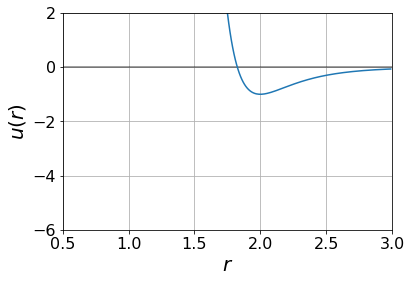

In [4]:
drs = np.arange(0.5,3,0.01)
U = u_function(drs)
plt.gca().axhline(y=0, color='k', alpha=0.5)
plt.xlim([0.5, 3.0])
plt.ylim([-6.0, 2.0])
plt.plot(drs,U)
format_plot(r'$r$', r'$u(r)$')
finalize_plot()

Visualising the Morse potential

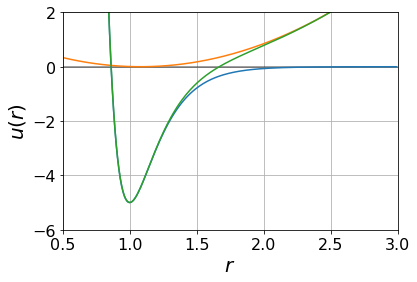

In [7]:
plt.gca().axhline(y=0, color='k', alpha=0.5)
plt.xlim([0.5, 3.0])
plt.ylim([-6.0, 2.0])

drs = np.arange(0.5, 3.0, 0.01)
plt.plot(drs, energy.morse(drs, sigma=1.0, epsilon=5.0, alpha=5.0))
plt.plot(drs, ca_h(drs))
plt.plot(drs, energy.morse(drs, sigma=1.0, epsilon=5.0, alpha=5.0) + ca_h(drs))

format_plot('$r$', '$u(r)$')

Adding the u-potential and Morse potential

In [8]:
def u_plus_morse(dr, s_hb, sigma, epsilon, alpha, **unused_kwargs):
  u_morse = u_function(dr, s_hb) + energy.morse(dr, sigma, epsilon, alpha)
  return np.array(u_morse, dtype=dr.dtype)

Averaging u-potential and Morse potential

In [9]:
def u_morse_avg(dr, s_hb, sigma, epsilon, alpha, **unused_kwargs):
  u_morse = u_function(dr, s_hb) + energy.morse(dr, sigma, epsilon, alpha)
  return np.array(u_morse/2, dtype=dr.dtype)

All potentials visualised together

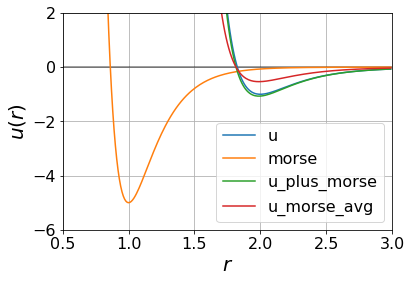

In [10]:
drs = np.arange(0.5,3,0.01)
u = u_function(drs)
morse = energy.morse(drs, sigma=1.0, epsilon=5.0, alpha=5.0)
u_morse = u_plus_morse(drs, s_hb=2.0, sigma=1.0, epsilon=5.0, alpha=5.0)
u_morse_avg = u_morse_avg(drs, s_hb=2.0, sigma=1.0, epsilon=5.0, alpha=5.0)
plt.gca().axhline(y=0, color='k', alpha=0.5)
plt.xlim([0.5, 3.0])
plt.ylim([-6.0, 2.0])
plt.plot(drs,u, label='u')
plt.plot(drs, morse, label='morse')
plt.plot(drs,u_morse, label='u_plus_morse')
plt.plot(drs, u_morse_avg, label='u_morse_avg')

plt.legend()
format_plot(r'$r$', r'$u(r)$')
finalize_plot()

In [11]:
def ca_h(dr, alpha=2.0, epsilon=1, r0=1.08, **kwargs):
  """Fixed Ca-H bond length."""
  return epsilon * (dr - r0) ** alpha

def ca_h_bond(displacement_or_metric, bond, bond_type=None, alpha=2.0, epsilon=1, r0=1.08):
  '''Convenience wrapper to maintain fix bond lengths between Ca and H atoms.'''
  alpha = np.array(alpha, f32)
  epsilon = np.array(epsilon, f32)
  r0 = np.array(r0, f32)
  return smap.bond(
      ca_h,
      space.canonicalize_displacement_or_metric(displacement_or_metric),
      bond,
      bond_type,
      alpha=alpha,
      epsilon=epsilon,
      r0=r0)


## Testing
This is the test part of the code, where I try to see if the bond length can be fixed while performing minimization.

[[5.   5.  ]
 [5.   6.08]
 [9.   9.  ]]


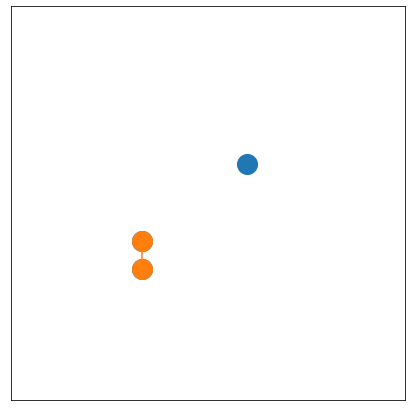

In [71]:
test_N = 3
test_dimension = 2
test_box_size = 15

test_key, test_split = random.split(key)
test_pair = np.array([[5.0, 5.0],
                      [5.0, 6.08]], dtype=f64)
test_atom = np.array([[9.0, 9.0]])
test_R = np.concatenate((test_pair, test_atom), axis=0)
print(test_R)

plot_system(test_R,test_box_size,paired_atoms=np.array([[0,1]]))

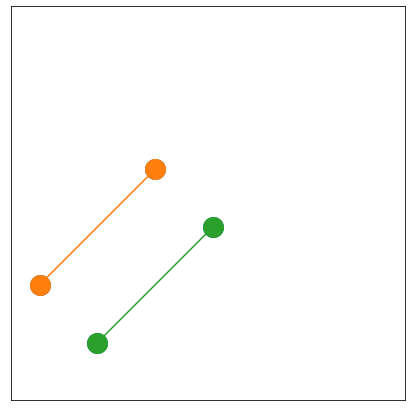

In [28]:
lulu = np.array([[1.1,4.4],
                 [3.3,2.2],
                 [5.5,8.8],
                 [7.7,6.6]])
poros = np.array([[0,2],
                  [1,3]])
plot_system(lulu,test_box_size, paired_atoms=poros)


In [52]:
test_displacement, test_shift = space.periodic(test_box_size)

In [53]:
# Create a function to calculate the total energy with specified parameters
test_energy_fn = u_function_pair(test_displacement, s_hb = 2.0)

# Use this to calculate the total energy
print(test_energy_fn(test_R))

# Use grad to calculate the net force
test_force = -grad(test_energy_fn)(test_R)
print(test_force)

5287.028224051456
[[ 2.00271606e-04 -6.40148789e+04]
 [ 9.44903240e-04  6.40148798e+04]
 [-1.14517485e-03 -8.90050971e-04]]


Run minimization using u-function as a potential and visualize how it changed the atom positions in the system.

largest component of force after minimization = 0.0374326155359542


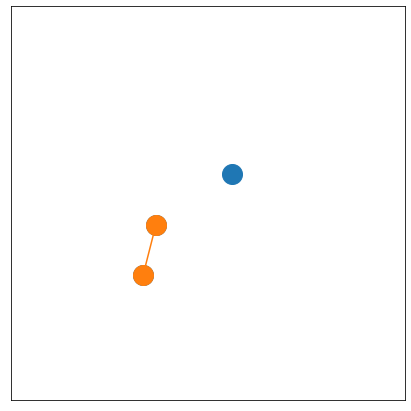

In [31]:
test_R_temp, test_max_force_component = run_minimization(test_energy_fn, test_R, test_shift)
print('largest component of force after minimization = {}'.format(test_max_force_component))
plot_system(test_R_temp, test_box_size, paired_atoms=np.array([[0,1]]))

In [32]:
print('Optimal distance between atoms in u-potential: 2.0')
print(f'Distance between paired atoms: {np.linalg.norm(test_R_temp[0]-test_R_temp[1])}')
print(f'Distance between lone atom and closest paired atom: {np.linalg.norm(test_R_temp[1]-test_R_temp[2])}')

Optimal distance between atoms in u-potential: 2.0
Distance between paired atoms: 2.0006099196788565
Distance between lone atom and closest paired atom: 3.487467888498015


In [54]:
test_bonds = np.array([[0,1]])
test_bond_energy_fn = ca_h_bond(test_displacement, test_bonds)

largest component of force after minimization = 8.04924951124444


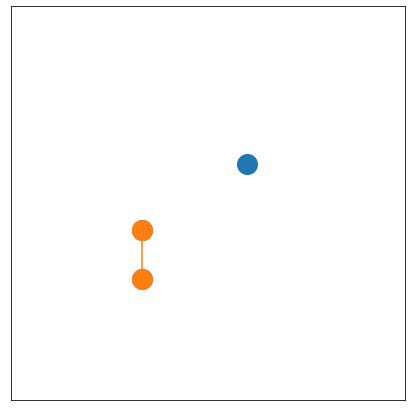

In [72]:
test_R_both_final, test_max_force_component = run_parallel_minimization(test_energy_fn, test_bond_energy_fn, test_R, test_shift, num_steps=1000)
print('largest component of force after minimization = {}'.format(test_max_force_component))
plot_system(test_R_both_final, test_box_size, paired_atoms=test_bonds)

In [74]:
print('Optimal distance between atoms in u-potential: 2.0')
print(f'Distance between paired atoms: {np.linalg.norm(test_R_both_final[0]-test_R_both_final[1])}')
print(f'Distance between lone atom and closest paired atom: {np.linalg.norm(test_R_both_final[1]-test_R_both_final[2])}')

Optimal distance between atoms in u-potential: 2.0
Distance between paired atoms: 1.8752810529178483
Distance between lone atom and closest paired atom: 4.728857357469811


largest component of force after minimization = 7.745681930232516e-15


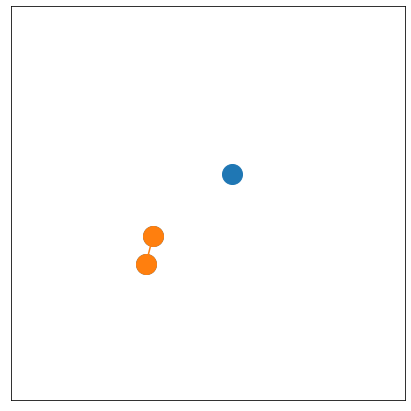

In [34]:
test_Rfinal, test_max_force_component = run_minimization(test_bond_energy_fn, test_R_temp, test_shift)
print('largest component of force after minimization = {}'.format(test_max_force_component))
plot_system(test_Rfinal, test_box_size, paired_atoms=test_bonds)

In [35]:
print('Optimal distance between atoms in u-potential: 2.0')
print(f'Distance between paired atoms: {np.linalg.norm(test_Rfinal[0]-test_Rfinal[1])}')
print(f'Distance between lone atom and closest paired atom: {np.linalg.norm(test_Rfinal[1]-test_Rfinal[2])}')

Optimal distance between atoms in u-potential: 2.0
Distance between paired atoms: 1.0800000429153402
Distance between lone atom and closest paired atom: 3.842321929559199


## Customizing potentials cookbook

### Calculate the energy of a system of interacting particles

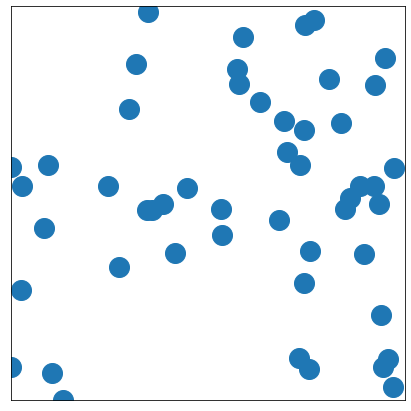

In [16]:
N = 50
dimension = 2
box_size = 12.5

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [17]:
displacement, shift = space.periodic(box_size)

In [18]:
def u_function_pair(
    displacement_or_metric, species=None, s_hb = 2.0): 
  s_hb = np.array(s_hb, dtype=f32)
  return smap.pair(
      u_function,
      space.canonicalize_displacement_or_metric(displacement_or_metric),
      species=species,
      s_hb=s_hb)

In [19]:
# Create a function to calculate the total energy with specified parameters
energy_fn = u_function_pair(displacement, s_hb = 2.0)

# Use this to calculate the total energy
print(energy_fn(R))

# Use grad to calculate the net force
force = -grad(energy_fn)(R)
print(force[:5])

49203184309125.95
[[-1.03833709e+03  9.54760685e+02]
 [-2.07953179e+07  8.58159755e+06]
 [-1.94080535e+04 -1.01028661e+05]
 [-3.55854768e+15  3.36683545e+14]
 [ 2.78804130e+10  6.76756612e+10]]


In [20]:
def run_minimization(energy_fn, R_init, shift, num_steps=5000):
  dt_start = 0.001
  dt_max   = 0.004
  init,apply=minimize.fire_descent(jit(energy_fn),shift,dt_start=dt_start,dt_max=dt_max)
  apply = jit(apply)

  @jit
  def scan_fn(state, i):
    return apply(state), 0.

  state = init(R_init)
  state, _ = lax.scan(scan_fn,state,np.arange(num_steps))

  return state.position, np.amax(np.abs(-grad(energy_fn)(state.position)))

In [70]:
def run_parallel_minimization(system_energy_fn, bond_energy_fn, R_init, shift, num_steps=1000):
  dt_start = 0.001
  dt_max   = 0.004
  init_system,apply_system=minimize.fire_descent(jit(system_energy_fn),shift,dt_start=dt_start,dt_max=dt_max)
  _, apply_bond = minimize.fire_descent(jit(bond_energy_fn),shift,dt_start=dt_start,dt_max=dt_max)
  apply_system = jit(apply_system)
  apply_bond = jit(apply_bond)

  for i in range(num_steps):
    @jit
    def scan_fn_system(state, i):
      return apply_system(state), 0.
    
    def scan_fn_bond(state, i):
      return apply_bond(state), 0.
    
    state = init_system(R_init)

    state, _ = lax.scan(scan_fn_system, state, np.arange(2))
    state, _ = lax.scan(scan_fn_bond, state, np.arange(10))
    R_init = state.position

  return state.position, np.amax(np.abs(-grad(energy_fn)(state.position)))


largest component of force after minimization = 7.66053886991358e-13


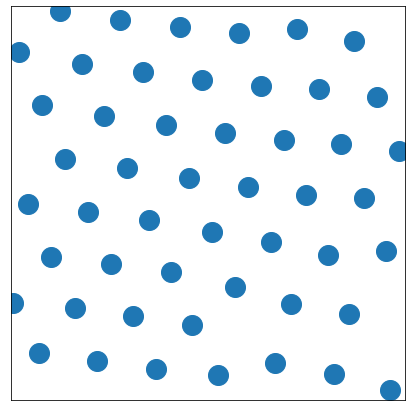

In [21]:
Rfinal, max_force_component = run_minimization(energy_fn, R, shift)
print('largest component of force after minimization = {}'.format(max_force_component))
plot_system( Rfinal, box_size)


### Creating a truncated potential

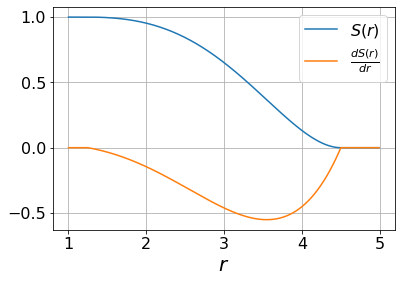

In [22]:
dr = np.arange(1.0,5,0.01)
S = energy.multiplicative_isotropic_cutoff(lambda dr:  1, r_onset=1.25, r_cutoff=4.5)(dr)
ngradS = vmap(grad(energy.multiplicative_isotropic_cutoff(lambda dr:  1, r_onset=1.25, r_cutoff=4.5)))(dr)
plt.plot(dr,S,label=r'$S(r)$')
plt.plot(dr,ngradS,label=r'$\frac{dS(r)}{dr}$')
plt.legend()
format_plot(r'$r$','')
finalize_plot()

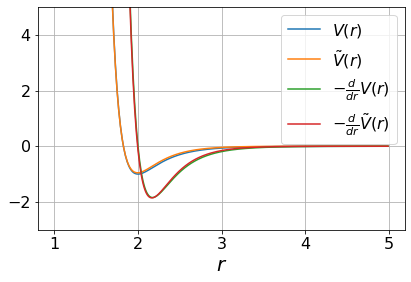

In [23]:
u_function_cutoff = energy.multiplicative_isotropic_cutoff(
    u_function, r_onset=1.25, r_cutoff=4.5)

dr = np.arange(1.0,5,0.01)
V = u_function(dr)
V_cutoff = u_function_cutoff(dr)
F = -vmap(grad(u_function))(dr)
F_cutoff = -vmap(grad(u_function_cutoff))(dr)
plt.plot(dr,V, label=r'$V(r)$')
plt.plot(dr,V_cutoff, label=r'$\tilde V(r)$')
plt.plot(dr,F, label=r'$-\frac{d}{dr} V(r)$')
plt.plot(dr,F_cutoff, label=r'$-\frac{d}{dr} \tilde V(r)$')
plt.legend()
format_plot('$r$', '')
plt.ylim(-3,5)
finalize_plot()

In [24]:
def u_function_cutoff_pair(
    displacement_or_metric, s_hb = 2.0, r_onset = 1.25, r_cutoff = 4.5):
  s_hb = np.array(s_hb, dtype=f32)
  return smap.pair(
      energy.multiplicative_isotropic_cutoff(
          u_function, r_onset=r_onset, r_cutoff=r_cutoff),
      space.canonicalize_displacement_or_metric(displacement_or_metric),
      s_hb=s_hb)

49203184309129.21
[[-1.03832694e+03  9.54883335e+02]
 [-2.07953177e+07  8.58159763e+06]
 [-1.94081367e+04 -1.01028635e+05]
 [-3.55854768e+15  3.36683545e+14]
 [ 2.78804130e+10  6.76756612e+10]]
largest component of force after minimization = 2.7105873101618272e-11


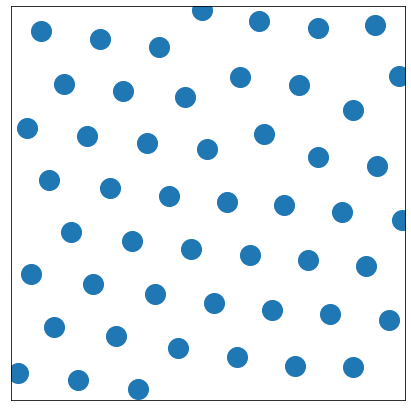

In [25]:
# Create a function to calculate the total energy
energy_fn = u_function_cutoff_pair(displacement, s_hb=2.0, r_onset=1.25, r_cutoff=4.5)

# Use this to calculate the total energy
print(energy_fn(R))

# Use grad to calculate the net force
force = -grad(energy_fn)(R)
print(force[:5])

# Minimize the energy using the FIRE algorithm
Rfinal, max_force_component = run_minimization(energy_fn, R, shift)
print('largest component of force after minimization = {}'.format(max_force_component))
plot_system( Rfinal, box_size )

In [26]:
print(energy_fn(Rfinal))
print(-grad(energy_fn)(Rfinal)[:5])

-56.69623723462198
[[-2.73070455e-12  3.09263726e-12]
 [ 1.46549439e-12  1.66799907e-12]
 [-1.10296217e-11  9.60853619e-12]
 [-8.88356055e-12  1.68665082e-12]
 [-4.22989421e-12 -3.22897264e-12]]
